# Apple Music Library Analysis

In this Jupyter Notebook, we import the Apple Music Library, which can be exported as an XML file directly from the Apple Music app on macOS. We then analyze it using Pandas to discover the most played songs, albums, and artists, along with other interesting KPIs. This analysis extends what was reported in the following **Medium** article:, [iTunes Library analysis using Python](https://leojosefm.medium.com/python-analyzing-itunes-library-97bec60e13cb).

## Reading the Apple Music Library XML

In [65]:
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from IPython.display import display, Image
import datetime

import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [66]:
def plot_df(df, kind, x, y, xlabel, ylabel, color, title):
    
    plt.clf()
    
    # Define fig, ax
    fig, ax = plt.subplots(figsize=(12,4))
    fig.suptitle(title)
    # Make plot
    if kind=='bar':
        plot = df.plot(kind=kind, x=x, y=y, color=color, ax=ax, width=0.95)
    else:
        plot = df.plot(kind=kind, x=x, y=y, color=color, ax=ax)
    # Set labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.tick_params(axis='x', rotation=80, labelsize=8)
    
    # Set legend
    legend = plt.legend()
    frame = legend.get_frame()
    frame.set_facecolor('white')

    return plot

In [67]:
parent_dir = 'LIBRARIES'

Below are the main functions used to read the XML tree structure, extract the relevant information (such as the tracklist), and build a Pandas dataframe for further analysis:

In [68]:
# Function to retrieve the tracklist from the XML structure:
def retrieve_tracklist(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    # Each song attribute is listed under the <dict> tag in the XML
    main_dict=root.findall('dict')
    for item in list(main_dict[0]):    
        if item.tag=="dict":
            tracks_dict=item
            break
    tracklist=list(tracks_dict.findall('dict'))
    
    return tracklist

**WARNING**: If the language on your computer is not set to Italian, you may need to replace the strings "File audio AAC acquistato" and "File audio AAC Apple Music" with the corresponding versions in your language.

In [69]:
# Function to create a list of purchased and apple music songs:
def create_lists(tracklist):
    purchased=[] # All purchased music
    apple_music=[] # Music added to library through subscription
    for item in tracklist:
        x=list(item)
        for i in range(len(x)):
            if x[i].text=="Kind" and x[i+1].text=="File audio AAC acquistato":
                purchased.append(list(item)) 
            if x[i].text=="Kind" and x[i+1].text=="File audio AAC Apple Music":
                apple_music.append(list(item))
    return purchased, apple_music

In [70]:
# Function to define columns in the Pandas Dataframe
def cols(kind):
    cols=[]
    for i in range(len(kind)):
        for j in range(len(kind[i])):
            if kind[i][j].tag=="key":
                cols.append(kind[i][j].text)
    return set(cols)

In [71]:
# Function to create the final Pandas Dataframe:
def df_creation(kind, cols):
    df = pd.DataFrame(columns=cols)
    df_list = []
    for row in kind:
        dict1 = {}
        for i in range(len(row) - 1):
            if row[i].tag == "key":
                dict1[row[i].text] = row[i+1].text
        if "Play Count" not in dict1:
            dict1["Play Count"] = 0
        list_values = [i for i in dict1.values()]
        list_keys = [j for j in dict1.keys()]
        df_temp = pd.DataFrame([list_values], columns=list_keys)
        df_list.append(df_temp)

    df = pd.concat(df_list, axis=0, ignore_index=True, sort=True)
    return df

In [72]:
columns_of_interest=['track_id','song_name','play_count','skip_count','album','artist' \
 ,'genre','kind','persistent_id','year_of_release','play_date','skip_date',\
 'release_date','date_modified']

When you export your Apple Music Library as an XML file, it includes a record of all the songs you've streamed since you started using the app. If you want to analyze your streaming habits on a monthly basis, you'll need to export your library at the end of each month (as explained in the README.md file) and run the following cells. These cells will combine each month's library into a single dataframe and generate a dataframe that shows the differences between each month.

In [100]:
# Initiliaze an empty list to hold the dataframes
df_list = []

# Loop through each folder
for folder in os.listdir(parent_dir):
    folder_path = os.path.join(parent_dir, folder)
    if os.path.isdir(folder_path):
        year = int(folder)
    
        # Loop through each file in the folder
        for file in os.listdir(folder_path):
            if file.startswith("music_library_"):
                date = file.split("_")[2][0:10]
                print(f"Reading {date} library file")
                file_path = os.path.join(folder_path, file)
    
                tracklist = retrieve_tracklist(file_path)
                
                # Create apple_music and purchased lists:
                purchased, apple_music = create_lists(tracklist)
                
                # Define columns:
                purchased_cols = cols(purchased)
                apple_music_cols = cols(apple_music)
                
                # Create Pandas Dataframe:
                df_purchased = df_creation(purchased,purchased_cols)
                df_apple_music = df_creation(apple_music,apple_music_cols)
                
                # Create a single dataframe for purchased and apple music songs:
                temp_apple = df_apple_music.loc[:,['Track ID','Name','Play Count','Skip Count','Album',\
                    'Artist','Genre','Kind','Persistent ID','Year','Play Date UTC',\
                    'Skip Date','Release Date','Date Modified']]
                temp_purchased = df_purchased.loc[:,['Track ID','Name','Play Count','Skip Count', \
                    'Album','Artist','Genre','Kind','Persistent ID','Year',\
                    'Play Date UTC','Skip Date','Release Date','Date Modified']]
                df_songs = pd.concat([temp_purchased,temp_apple],axis = 0)
                df_songs.columns = columns_of_interest
                
                # Cast columns to appropriate datatypes
                df_songs[['track_id','play_count','skip_count','year_of_release']] = df_songs[['track_id',\
                    'play_count','skip_count','year_of_release']].apply(pd.to_numeric)
                df_songs[['play_date','skip_date','release_date','date_modified']] = df_songs[['play_date',\
                    'skip_date','release_date','date_modified']].apply(pd.to_datetime)
                
                # Create date columns (corresponding to the specific photograph of the Library)
                df_songs['date'] = datetime.datetime.strptime(date, '%Y-%m-%d')
                df_songs['year'] = df_songs['date'].dt.year
                df_songs['month'] = df_songs['date'].dt.month
                df_songs['week'] = df_songs['date'].dt.isocalendar().week
                
                # Removing duplicates keeping track_id with highest play_count
                df_songs = df_songs.sort_values(['song_name', 'artist', 'album','play_count'], 
                                                ascending=[True, True, True, False])

                # drop duplicated rows and keep the one with the highest play_count
                df_songs = df_songs.drop_duplicates(subset=['song_name', 'artist','album'], keep='first')
                
                # Append the dataframe to the list
                df_list.append(df_songs)
                
                
# Concatenate all the dataframes into a single dataframe
df_library_history = pd.concat(df_list, ignore_index=True)

Reading 2023-02-28 library file
Reading 2023-03-18 library file


In [101]:
df_library_history.head(10)

,track_id,song_name,play_count,skip_count,album,artist,genre,kind,persistent_id,year_of_release,play_date,skip_date,release_date,date_modified,date,year,month,week
0,2490,!ly (feat. Coez),27,8.0,c@ra++ere s?ec!@le,thasup,Hip-Hop/Rap,File audio AAC Apple Music,272ECF012768C0B3,2022,2022-12-29 19:38:25+00:00,2023-01-11 07:26:29+00:00,2022-09-30 12:00:00+00:00,2022-09-30 16:28:01+00:00,2023-02-28,2023,2,9
1,1852,$$$,0,1.0,?,XXXTENTACION & Matt OX,Pop,File audio AAC Apple Music,87E4A70C531E8E9B,2018,NaT,2022-07-17 14:59:56+00:00,2018-03-16 12:00:00+00:00,2022-02-19 15:08:48+00:00,2023-02-28,2023,2,9
2,883,$€ Freestyle,1,NaN,Famoso,Sfera Ebbasta,Hip-Hop/Rap,File audio AAC Apple Music,244F11944C8FA851,2020,2021-12-22 20:02:49+00:00,NaT,2020-11-20 08:00:00+00:00,2021-12-21 21:12:23+00:00,2023-02-28,2023,2,9
3,1204,'A verità (feat. Enzo Avitabile),0,1.0,'A verità (Special Edition),Rocco Hunt,Hip-Hop/Rap,File audio AAC Apple Music,718ECE37465DA502,2014,NaT,2022-08-28 15:21:24+00:00,2014-03-25 12:00:00+00:00,2021-12-24 22:18:27+00:00,2023-02-28,2023,2,9
4,2480,(SEMBRA BELLO),0,NaN,FARSI MALE A NOI VA BENE 2.0,bnkr44,Pop,File audio AAC Apple Music,741E1E21E54A1340,2021,NaT,NaT,2021-11-18 12:00:00+00:00,2022-09-23 17:22:21+00:00,2023-02-28,2023,2,9
5,1403,(arrivo?),2,1.0,DOOM,Nayt & 3D,Hip-Hop/Rap,File audio AAC Apple Music,5450451CDA768E95,2021,2022-01-07 16:30:38+00:00,2022-01-06 19:05:28+00:00,2021-10-29 12:00:00+00:00,2021-12-30 14:30:37+00:00,2023-02-28,2023,2,9
6,1401,(partenza),1,1.0,DOOM,Nayt & 3D,Hip-Hop/Rap,File audio AAC Apple Music,349736F77B764395,2021,2021-12-30 14:48:32+00:00,2022-01-22 22:58:57+00:00,2021-10-29 12:00:00+00:00,2021-12-30 14:30:37+00:00,2023-02-28,2023,2,9
7,379,+ -,0,NaN,Controcultura (Bonus Track Version),Fabri Fibra,Hip-Hop/Rap,File audio AAC Apple Music,EB448ACA41E1150F,2010,NaT,NaT,2010-09-07 12:00:00+00:00,2021-12-02 08:25:54+00:00,2023-02-28,2023,2,9
8,2506,+ bla se c'è bling,46,2.0,c@ra++ere s?ec!@le,thasup,Hip-Hop/Rap,File audio AAC Apple Music,9090F97EC3C4E17C,2022,2022-12-29 19:45:24+00:00,2022-12-28 11:26:34+00:00,2022-09-30 12:00:00+00:00,2022-09-30 16:28:01+00:00,2023-02-28,2023,2,9
9,1071,...Ein Tag Aus Dem Leben Des Kleinen Johannes ...,0,1.0,L'Imboscata (25th Anniversary),Franco Battiato,Pop,File audio AAC Apple Music,89DEF1A2B6639968,1996,NaT,2022-12-09 15:44:18+00:00,1996-10-23 12:00:00+00:00,2021-12-22 18:29:40+00:00,2023-02-28,2023,2,9


### Generate DataFrame of Differences

In [111]:
first_day_avail = df_library_history['date'].min()
print(f'First Library available relative to date: {first_day_avail}')

First Library available relative to date: 2023-02-28 00:00:00


In [120]:
# group the dataframe by song and sort each group by date
df_diff = df_library_history.groupby(['song_name', 'artist', 'album']).apply(lambda x: x.sort_values('date'))

# generate a column with the play count corresponding to the previous date available for each song
df_diff['prev_play_count'] = df_diff.groupby(['song_name', 'artist', 'album'])['play_count'].apply(lambda x: x.shift(1).fillna(method='ffill'))

# fill the missing values with 0
df_diff['prev_play_count'] = df_diff['prev_play_count'].fillna(0)

# Compute play_count of weekly streamed songs
df_diff['stream'] = df_diff['play_count']-df_diff['prev_play_count']

# Eliminate songs with <=0 streams
df_diff = df_diff[df_diff['stream']>0]

# Eliminate first library occurence
df_diff = df_diff[df_diff['date']!=first_day_avail]

In [121]:
# print the result
display(df_diff[['song_name', 'artist', 
                        'album', 'stream', 'date', 'week']]\
        .sort_values(by=['date', 'stream'], ascending=[False, False]).head(5))

,song_name,artist,album,stream,date,week
3142,CENERE,Lazza,CENERE - Single,30.0,2023-03-18,11
3814,IL BENE NEL MALE,Madame,IL BENE NEL MALE - Single,30.0,2023-03-18,11
4474,No wallet,Paky & Marracash,Salvatore,23.0,2023-03-18,11
4451,Niente canzoni d'amore,Elodie,This Is Elodie,18.0,2023-03-18,11
3481,Due Vite,Marco Mengoni,Due Vite - Single,17.0,2023-03-18,11


### Data Cleaning

In [122]:
# Replacing different words for "Rap" genre with "Hip-Hop":
replacements = {'Hip Hop/Rap': 'Hip-Hop/Rap', 
                'Hip Hop': 'Hip-Hop/Rap',
                'Hip-Hop': 'Hip-Hop/Rap'
               
               }
df_library_history['genre'] = df_library_history['genre'].replace(replacements)
df_diff['genre'] = df_diff['genre'].replace(replacements)

## Point-In-Time Analysis

To begin our analysis, let's examine the library at a specific point in time to identify which songs and albums were the most streamed at that moment in the past.

In [23]:
# Time variable definition:
date = '2023-02-10'
target_date = datetime.datetime.strptime(date, '%Y-%m-%d')

# Calculate absolute difference with target date
df_library_history['diff'] = (df_library_history['date'] - target_date).abs()

# find the row with the smallest difference
closest_date_row = df_library_history.loc[df_library_history['diff'].idxmin()]

# print the result
print(closest_date_row.date)

2023-02-28 00:00:00


In [24]:
# Filter dataframe
df_month = df_library_history[df_library_history['date']==closest_date_row.date]

To facilitate further analysis, it would be useful to have a dataframe that lists only the albums and their corresponding artists. Because it may happen that collaborative songs (with multiple artists) are recorded as a single artist song, we cannot make a simple distinct list of artists and albums. Below is the code to extract the album/artist distinct couples:

In [25]:
# Find artist of each album
all_albums = df_month.groupby(['album', 'artist']).size().to_frame().reset_index()
all_albums = all_albums.rename(columns={0: 'song_count'})

all_albums = all_albums.loc[all_albums.groupby('album')['song_count'].idxmax()]
all_albums = all_albums[['album', 'artist']]

# Remove album names containing 'Single':
all_albums = all_albums[~all_albums['album'].str.contains('Single')]

display(all_albums.head(10))

,album,artist
0,'A verità (Special Edition),Rocco Hunt
1,12000 Lune,Lucio Dalla
3,17,Emis Killa & Jake La Furia
9,1969 - Achille Idol Rebirth,Achille Lauro
10,20,Capo Plaza
11,21,Adele
12,23 6451,thasup
21,25,Adele
22,30,Adele
23,8 Mile (Music from and Inspired By the Motion ...,Eminem


### Top Genre, Artist, Songs and Albums

We are now ready to construct and plot the most common charts used when analyzing music data. If you wish to adjust the number of elements displayed on each chart, please modify the following parameter:

In [26]:
# Top N charts
n_topcharts = 30

In [27]:
# Top Genres
df_genres_count = df_month.groupby('genre')['play_count'].sum().to_frame().reset_index()

topN_genre = df_genres_count.sort_values(by='play_count', ascending=False).head(n_topcharts)

<Figure size 640x480 with 0 Axes>

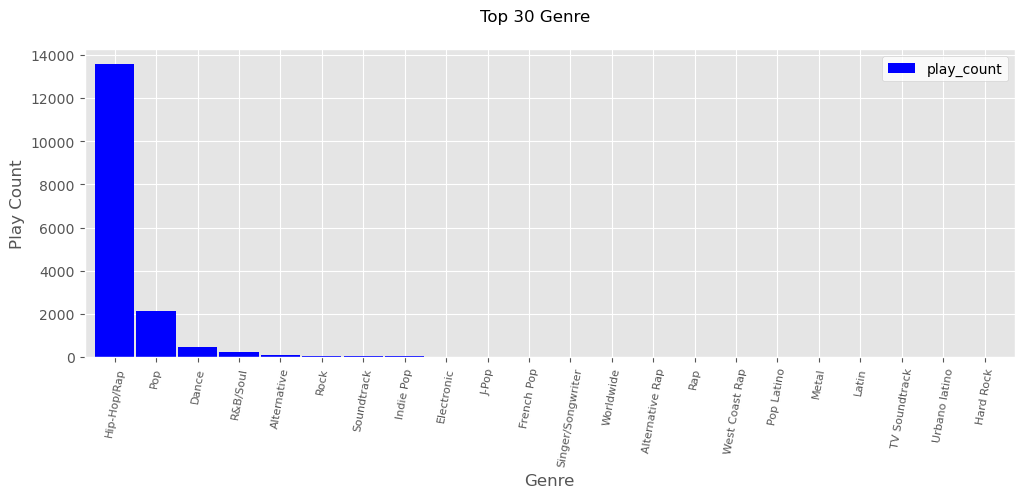

In [28]:
%matplotlib inline
plot_genre = plot_df(topN_genre, 'bar', 'genre', 'play_count', 'Genre', 'Play Count', 
                     'blue', f'Top {n_topcharts} Genre')

In [29]:
# Top Artists
df_artist_count = df_month.groupby('artist')['play_count'].sum().to_frame().reset_index()
topN_artist= df_artist_count.sort_values(by='play_count', ascending=False).head(n_topcharts)

<Figure size 640x480 with 0 Axes>

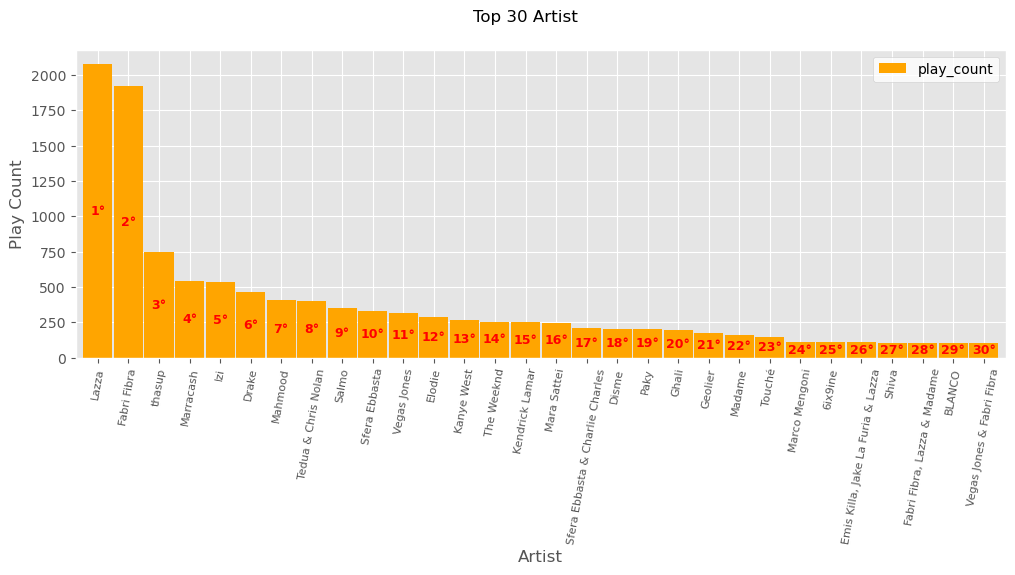

In [30]:
plot_artist = plot_df(topN_artist, 'bar', 'artist', 'play_count', 'Artist', 'Play Count', 
                      'orange', f'Top {n_topcharts} Artist')


for i, n in enumerate(topN_artist['play_count']):
    height = n
    plot_artist.text(x=i, y=height/2, s=str(i+1)+'°', ha='center', va='center', 
                   rotation=0, fontsize=9, fontweight='bold', color='red')

<Figure size 640x480 with 0 Axes>

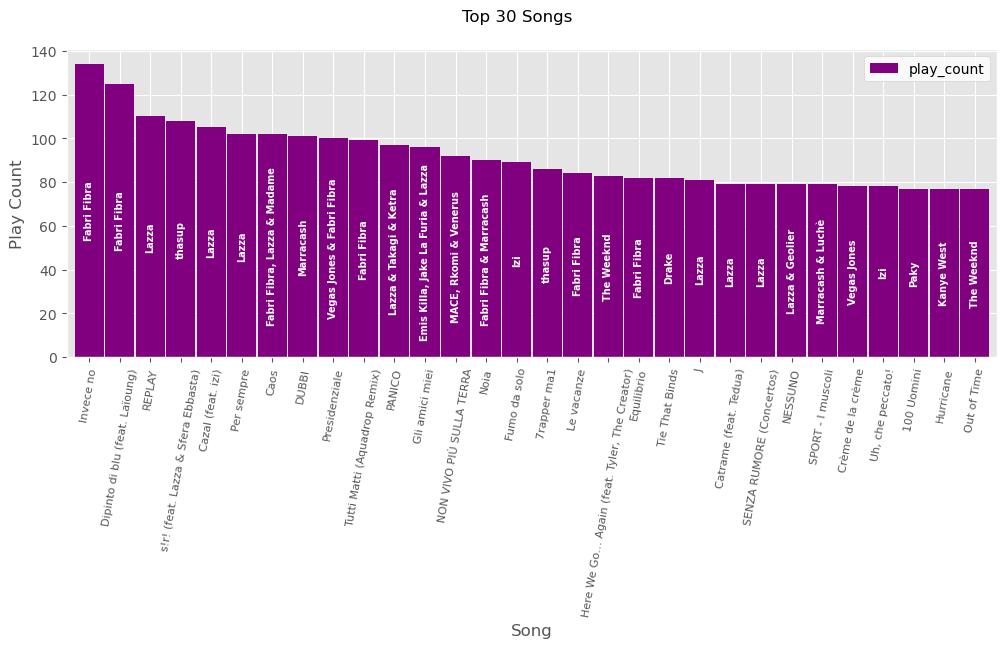

In [31]:
# Top Songs 
topN_songs =  df_month[['song_name', 'artist', 'play_count']].sort_values(by='play_count', ascending=False)\
    .head(n_topcharts)

plot_songs = plot_df(topN_songs, 'bar', 'song_name', 'play_count', 'Song', 'Play Count', 
                     'purple', f'Top {n_topcharts} Songs')

for i, pc in enumerate(topN_songs['play_count']):
    height = pc
    artist = topN_songs.iloc[i,1]
    plot_songs.text(x=i, y=height/2, s=str(artist), ha='center', va='center', 
                   rotation=90, fontsize=7, fontweight='bold', color='white')

It may also be interesting to see which are the artist with the most songs in the Top (N) Chart:

In [32]:
# Find distint songs per artist in Top N
nsongs_in_topN = topN_songs.groupby('artist')['song_name'].nunique().to_frame().reset_index()
nsongs_in_topN = nsongs_in_topN.rename(columns={'song_name':'n_songs'})
nsongs_in_topN = nsongs_in_topN.sort_values(by='n_songs', ascending=False)

<Figure size 640x480 with 0 Axes>

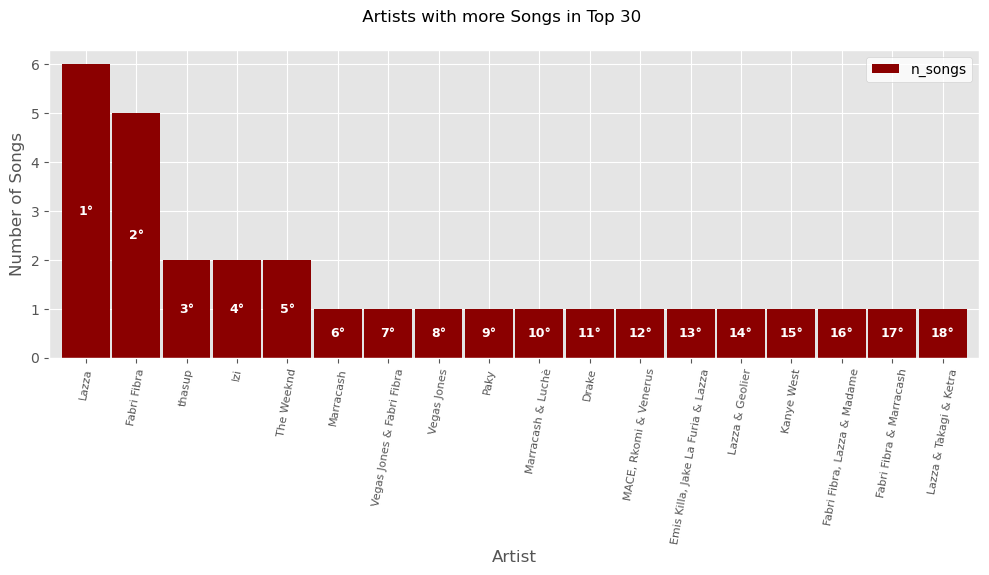

In [33]:
plot_nsongs_in_topN = plot_df(nsongs_in_topN, 'bar', 'artist', 'n_songs', 'Artist', 'Number of Songs', 
                     'darkred', f' Artists with more Songs in Top {n_topcharts}')

for i, nsongs in enumerate(nsongs_in_topN['n_songs']):
    height = nsongs
    plot_nsongs_in_topN.text(x=i, y=height/2, s=str(i+1)+'°', ha='center', va='center', 
                   rotation=0, fontsize=9, fontweight='bold', color='white')

<Figure size 640x480 with 0 Axes>

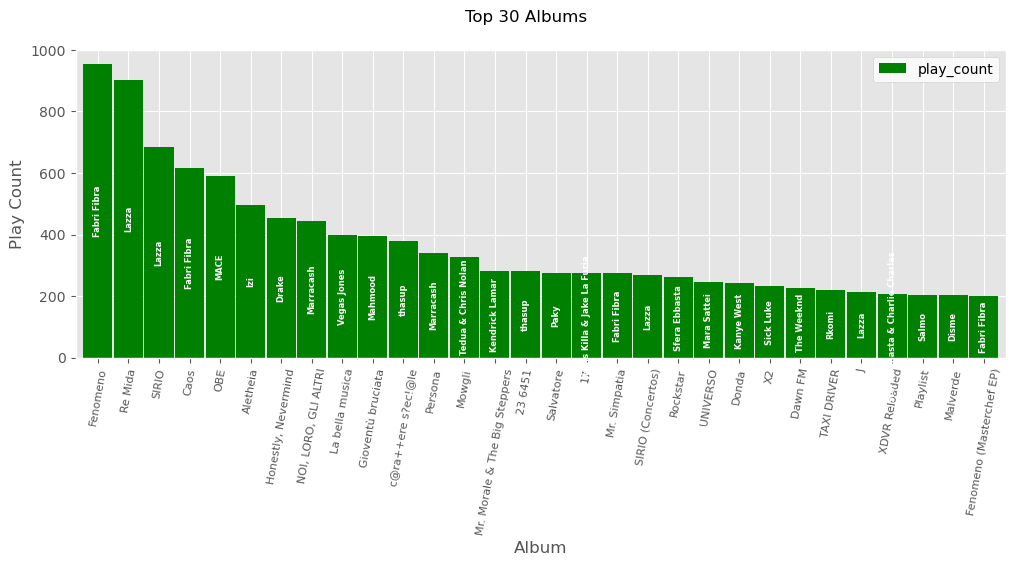

In [34]:
# Top Albums
topN_albums =  df_month.groupby('album')['play_count'].sum().to_frame().reset_index()\
    .sort_values(by='play_count', ascending=False).head(n_topcharts)

# Join with all_albums
topN_albums = topN_albums.merge(all_albums, on='album', how='left')

plot_albums = plot_df(topN_albums, 'bar', 'album', 'play_count', 'Album', 'Play Count', 
                      'green', f'Top {n_topcharts} Albums')

for i, pc in enumerate(topN_albums['play_count']):
    height = pc
    artist = topN_albums.iloc[i,2]
    plot_albums.text(x=i, y=height/2, s=str(artist), ha='center', va='center', 
                   rotation=90, fontsize=6, fontweight='bold', color='white')

### Other KPI

Next, let's see which artists are the most represented (in terms of distinct songs) in our library:

In [35]:
# Find total number of songs per each artist
artist_songs = df_month.groupby('artist')['song_name'].nunique().to_frame().reset_index()

top10_artist_songs = artist_songs.sort_values(by='song_name', ascending=False).head(10)

# Find total number of songs
tot_songs = df_month['song_name'].nunique()
tot_songs_by_top10 = top10_artist_songs['song_name'].sum()

other_songs = tot_songs-tot_songs_by_top10
top10_artist_songs.loc[10] = ['Altri', other_songs]

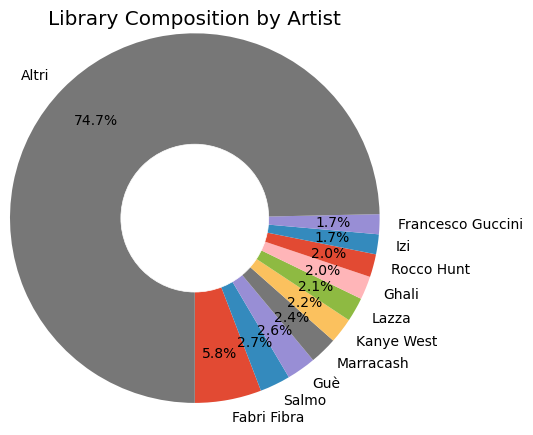

In [36]:
# Create a sample dataframe
data = {'label': ['A', 'B', 'C', 'D'],
        'value': [25, 20, 30, 15]}
df = pd.DataFrame(data)

# Create a donut chart
fig, ax = plt.subplots()

# Create the outer ring of the donut chart
wedges, texts, autotexts = ax.pie(top10_artist_songs['song_name'], labels=top10_artist_songs['artist'], autopct='%1.1f%%', startangle=-90, pctdistance=0.75, radius=1.25)

# Create the inner circle of the donut chart
circle = plt.Circle(xy=(0, 0), radius=0.5, color='white')
ax.add_artist(circle)

# Set the title
ax.set_title('Library Composition by Artist')

# Show the plot
plt.show()

Which artists have the most albums?

In [37]:
# Find Artist with the most albums:
n_topartist_by_album = 20 
n_albums_per_artist = all_albums.groupby('artist')['album'].nunique().to_frame().reset_index()
n_albums_per_artist = n_albums_per_artist.rename(columns={'album':'n_albums'})

top_artist_by_n_albums = n_albums_per_artist.sort_values(by='n_albums', ascending=False).head(n_topartist_by_album)

<Figure size 640x480 with 0 Axes>

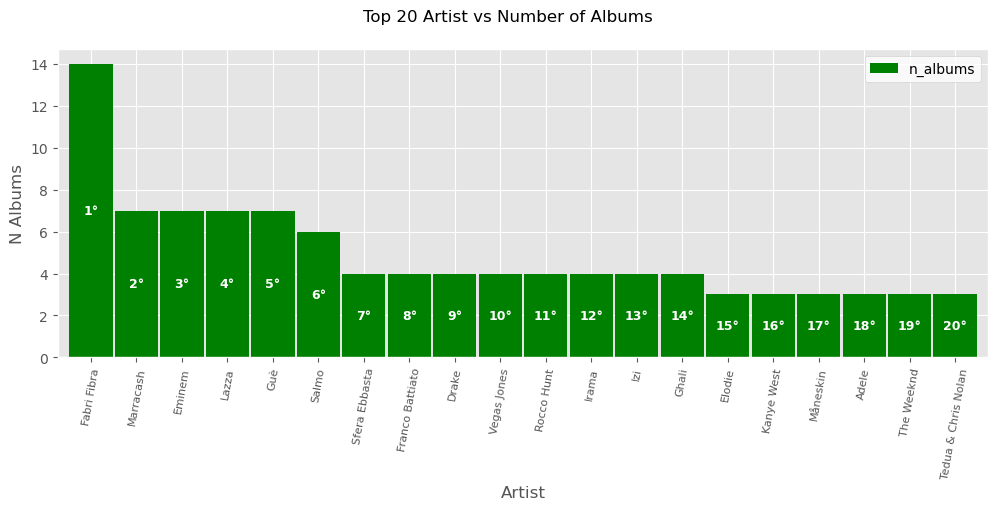

In [38]:
plot_artist_by_n_albums = plot_df(top_artist_by_n_albums, 'bar', 'artist', 'n_albums', 'Artist', 'N Albums', 
                      'green', f'Top {n_topartist_by_album} Artist vs Number of Albums')

for i, nalbums in enumerate(top_artist_by_n_albums['n_albums']):
    height = nalbums
    plot_artist_by_n_albums.text(x=i, y=height/2, s=str(i+1)+'°', ha='center', va='center', 
                   rotation=0, fontsize=9, fontweight='bold', color='white')

In addition to the TOP charts considered above, let now turn our attention to other useful KPIs which can help us understanding better our music habits. First of all, can we quantify how much we listen to an artist in relation to the extent of its music library? To answer this question we can define the following quantity:

$$ 
\xi_A = \frac{\sum_{i, pc>=1}^{N} (pc)_i}{N}
$$

that is, we sum all the play counts ($pc$) generated by an artist $A$ and divide the result by the total number of songs of the artist. However, we restrict our attention just to those songs that we have listened at least one time ($pc>=1$). Let's code!

In [39]:
df_songs_played  = df_month[df_month['play_count']>=1]

df_pc_artist = df_songs_played.groupby('artist')['play_count'].sum().to_frame().reset_index()
df_total_songs_artist = df_songs_played.groupby('artist')['song_name'].nunique().to_frame().reset_index()
df_total_songs_artist = df_total_songs_artist.rename(columns={'song_name':'n_songs'})
df_total_songs_artist = df_total_songs_artist[df_total_songs_artist['n_songs']>1]

#display(df_pc_artist.sort_values(by='play_count', ascending=False).head(10))
#display(df_total_songs_artist.sort_values(by='n_songs', ascending=False).head(10))

In [40]:
# Join on Artist
df_join_xi = df_pc_artist.merge(df_total_songs_artist, on='artist', how='inner')
df_join_xi['xi'] = round(df_join_xi['play_count']/df_join_xi['n_songs'], 2)
topN_xi = df_join_xi.sort_values(by='xi', ascending=False).head(n_topcharts)

<Figure size 640x480 with 0 Axes>

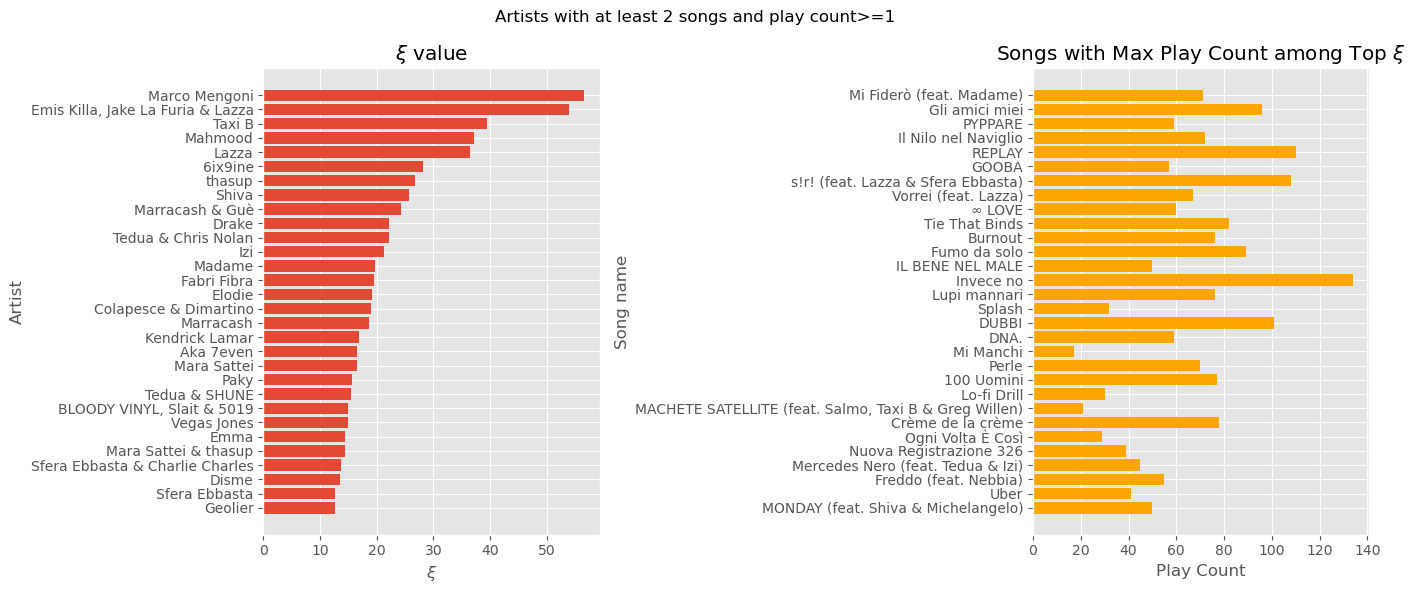

In [41]:
# Let also see what songs of the above artists have been streamed the most
artist_list = list(topN_xi['artist'])
df_artist_topxi = df_month[df_month['artist'].isin(artist_list)]
idx = df_artist_topxi.groupby('artist')['play_count'].idxmax()

df_songs_topxi = df_artist_topxi.loc[idx][['artist', 'song_name', 'play_count']]

df_songs_topxi['artist'] = pd.Categorical(df_songs_topxi['artist'], categories=artist_list, ordered=True)
df_songs_topxi = df_songs_topxi.sort_values(by='artist')
#display(df_songs_topxi)


# Creating a bar plot
plt.clf()
    
# Define fig, ax
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
fig.suptitle('Artists with at least 2 songs and play count>=1')

# Make bar plot
ax1.barh(topN_xi['artist'], topN_xi['xi'])
ax1.set_xlabel(r'$\xi$')
ax1.set_ylabel('Artist')
ax1.set_yticks(topN_xi['artist'])
ax1.invert_yaxis()
ax1.set_title(r'$\xi$ value')

# Make the second bar plot
ax2.barh(df_songs_topxi['song_name'], df_songs_topxi['play_count'], color='orange')
ax2.set_xlabel('Play Count')
ax2.set_ylabel('Song name')
ax2.set_yticks(df_songs_topxi['song_name'])
ax2.invert_yaxis()
ax2.set_title(r'Songs with Max Play Count among Top $\xi$')

plt.tight_layout()

If we also include songs with a play count of zero, the situation may be significantly different. In this case, the corresponding $\xi$ provides a more accurate measure of the degree to which an artist's song library is being "consumed". In addition, in the Apple Music Library, collaborative songs may be recorded as a distinct artist. In some cases, such a "new" artist may only be associated with few songs (maybe one or two), thus resulting in an increase in $\xi$. To avoid this, we may consider artists with at least 3 songs:

In [42]:
# Considering all songs:
df_pc_artist_full = df_month.groupby('artist')['play_count'].sum().to_frame().reset_index()
df_total_songs_artist_full = df_month.groupby('artist')['song_name'].nunique().to_frame().reset_index()
df_total_songs_artist_full = df_total_songs_artist_full.rename(columns={'song_name':'n_songs'})
df_total_songs_artist_full = df_total_songs_artist_full[df_total_songs_artist_full['n_songs']>=3]

# Join 
df_join_xi_full = df_pc_artist_full.merge(df_total_songs_artist_full, on='artist', how='inner')
df_join_xi_full['xi'] = round(df_join_xi_full['play_count']/df_join_xi_full['n_songs'], 2)
topN_xi_full = df_join_xi_full.sort_values(by='xi', ascending=False).head(n_topcharts)

# Let also see what songs of the above artists have been streamed the most
artist_list_full = list(topN_xi_full['artist'])
df_artist_topxi_full = df_month[df_month['artist'].isin(artist_list_full)]
idx_full = df_artist_topxi_full.groupby('artist')['play_count'].idxmax()

df_songs_topxi_full = df_artist_topxi_full.loc[idx_full][['artist', 'song_name', 'play_count']]

df_songs_topxi_full['artist'] = pd.Categorical(df_songs_topxi_full['artist'], categories=artist_list_full, ordered=True)
df_songs_topxi_full = df_songs_topxi_full.sort_values(by='artist')

<Figure size 640x480 with 0 Axes>

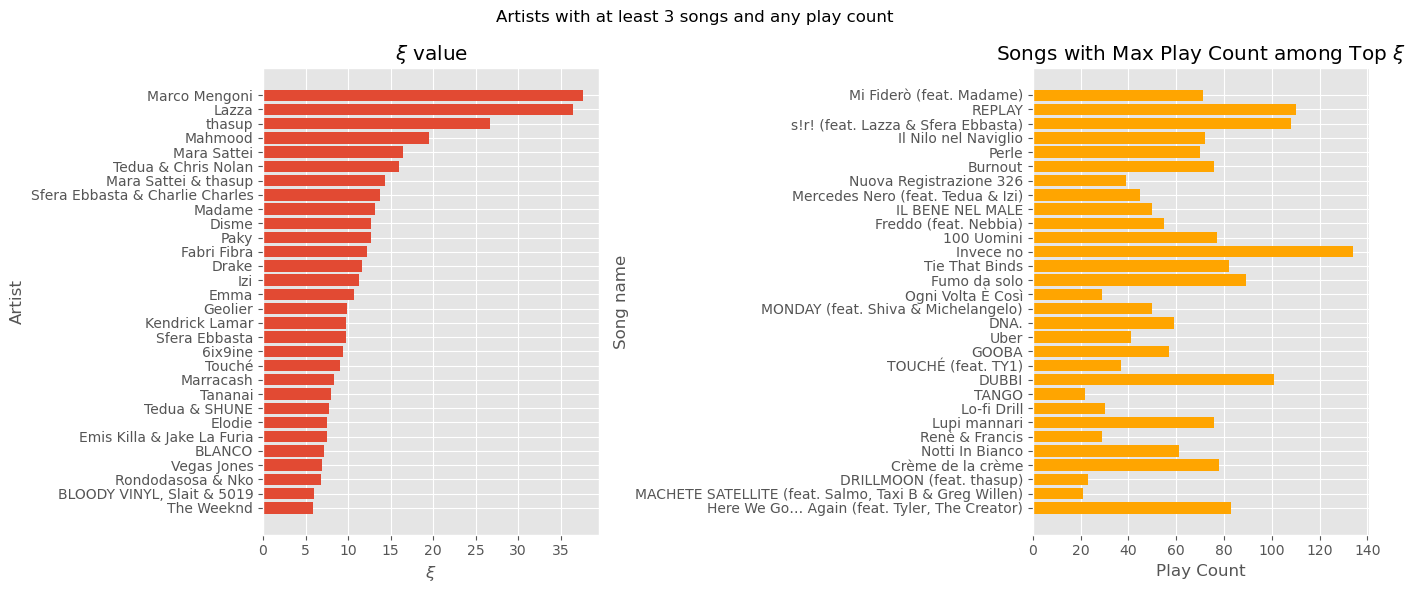

In [43]:
# Creating a bar plot
plt.clf()
    
# Define fig, ax
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
fig.suptitle('Artists with at least 3 songs and any play count')

# Make bar plot
ax1.barh(topN_xi_full['artist'], topN_xi_full['xi'])
ax1.set_xlabel(r'$\xi$')
ax1.set_ylabel('Artist')
ax1.set_yticks(topN_xi_full['artist'])
ax1.invert_yaxis()
ax1.set_title(r'$\xi$ value')

# Make the second bar plot
ax2.barh(df_songs_topxi_full['song_name'], df_songs_topxi_full['play_count'], color='orange')
ax2.set_xlabel('Play Count')
ax2.set_ylabel('Song name')
ax2.set_yticks(df_songs_topxi_full['song_name'])
ax2.invert_yaxis()
ax2.set_title(r'Songs with Max Play Count among Top $\xi$')

plt.tight_layout()

To analyze albums, we can replicate the above methodology by defining a $\xi$ quantity as the total play count of all songs divided by the number of songs in the album. To make it more reasonable, we will limit our analysis to a subset of the albums in the library. Specifically, we will focus on albums that have at least 10 songs and where at least two songs have more than 1 play count.

In [44]:
# Group by album and count the number of songs with play count >= 1
album_counts = df_month[df_month['play_count'] >= 1].groupby('album')['song_name'].count()

# Filter for albums with at least two songs with play count >= 1
filtered_albums = album_counts[album_counts >= 2].index

# Filter the original dataframe for the selected albums
filtered_df_month = df_month[df_month['album'].isin(filtered_albums)]

# Group by album, find total play_count and distinct songs
df_pc_albums = filtered_df_month.groupby('album').agg(
    play_count=('play_count', 'sum'),
    distinct_songs=('song_name', 'nunique')
).reset_index()

# Compute xi
df_pc_albums['xi'] = round(df_pc_albums['play_count']/df_pc_albums['distinct_songs'], 2)
topN_xi_albums = df_pc_albums.sort_values(by='xi', ascending=False).head(n_topcharts)

<Figure size 640x480 with 0 Axes>

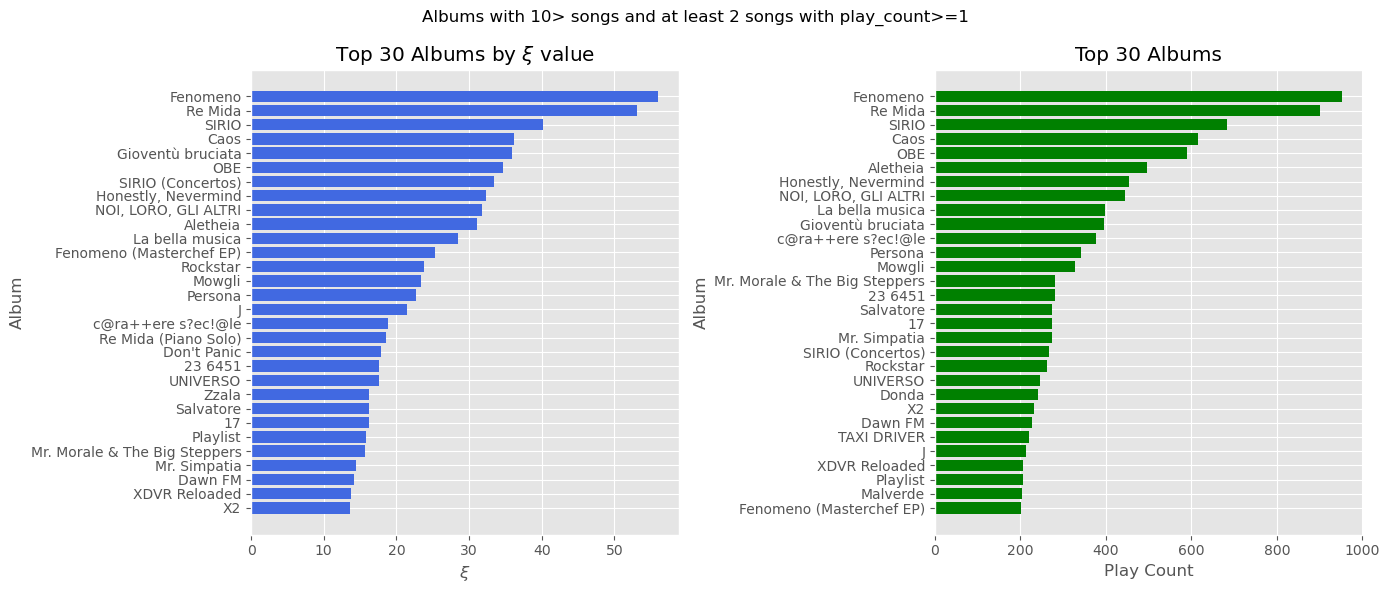

In [45]:
# Creating a bar plot
plt.clf()
    
# Define fig, ax
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
fig.suptitle('Albums with 10> songs and at least 2 songs with play_count>=1')

# Make bar plot
ax1.barh(topN_xi_albums['album'], topN_xi_albums['xi'], color='royalblue')
ax1.set_xlabel(r'$\xi$')
ax1.set_ylabel('Album')
ax1.set_yticks(topN_xi_albums['album'])
ax1.invert_yaxis()
ax1.set_title(fr'Top {n_topcharts} Albums by $\xi$ value')

# Make the second bar plot
ax2.barh(topN_albums['album'], topN_albums['play_count'], color='green')
ax2.set_xlabel('Play Count')
ax2.set_ylabel('Album')
ax2.set_yticks(topN_albums['album'])
ax2.invert_yaxis()
ax2.set_title(fr'Top {n_topcharts} Albums')

plt.tight_layout()

Another interesting analysis we could perform, based on a photograph of the music library, is to identify the years in which the most highly appreciated songs were released. To accomplish this, we can group the songs by their year of release and compute the total play count generated by all songs released in each year.

<Figure size 640x480 with 0 Axes>

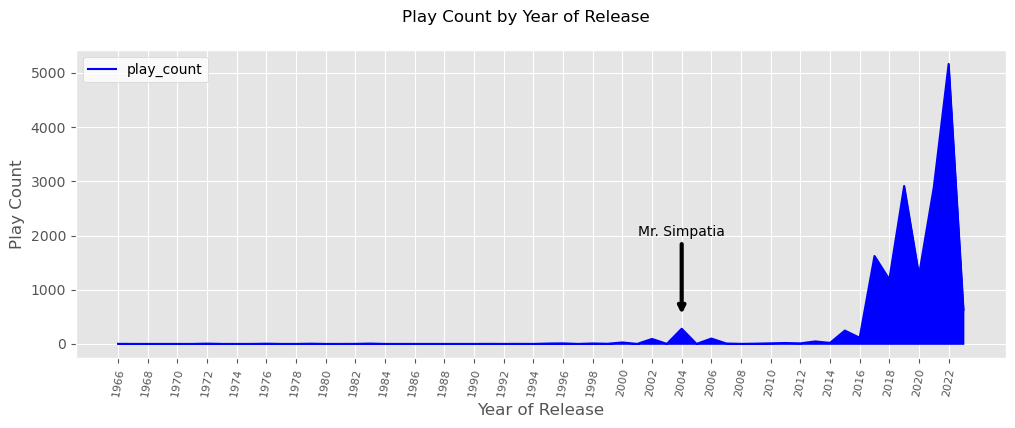

In [46]:
# Compute total play count by year of release
year_release_pc = df_month.groupby('year_of_release')['play_count'].sum().to_frame().reset_index()

# Complete the dataframe
year_release_pc = year_release_pc.set_index('year_of_release')

# create a new index with all the years from the minimum to the maximum
new_index = pd.Index(range(year_release_pc.index.min(), year_release_pc.index.max() + 1), name='year_of_release')

# reindex the dataframe with the new index, filling missing values with zeros
year_release_pc = year_release_pc.reindex(new_index, fill_value=0).reset_index()

#display(year_release_pc)

yr_lineplot = plot_df(year_release_pc, 'line', 'year_of_release', 
                      'play_count', 'Year of Release', 'Play Count', 'blue', 'Play Count by Year of Release')

yr_lineplot.fill_between(year_release_pc['year_of_release'], year_release_pc['play_count'], 0, color='blue')
yr_lineplot.set_xticks(range(
    min(year_release_pc['year_of_release']),
    max(year_release_pc['year_of_release']),
    2))


# Customize plot
df_2004 = df_month[df_month['year_of_release']==2004]
top2004_album = df_2004.groupby('album')['play_count'].sum().to_frame().reset_index()\
    .sort_values(by='play_count', ascending=False).head(1).iloc[0,0]

arrow = yr_lineplot.annotate(top2004_album,
             xy=(2004, 500),  #location of the arrow
             xytext=(2004, 2000),  # location of the string
             horizontalalignment="center",
             arrowprops=dict(arrowstyle='->', color='black', lw=3))  # arrow properties

To conclude our point-in-time analysis, let's see which albums were the most streamed in each release year:

In [47]:
# Find top 5 albums each year (using filtered_df_month)
top3_album_yr = filtered_df_month.groupby(['year_of_release', 'album'])['play_count'].sum().to_frame().reset_index()

top3_album_yr = top3_album_yr.merge(year_release_pc, on='year_of_release', how='left')
top3_album_yr = top3_album_yr.rename(columns={'play_count_x':'play_count_album', 'play_count_y':'play_count_year'})

# Computing %
top3_album_yr['%_pc'] = round(top3_album_yr['play_count_album']/top3_album_yr['play_count_year']*100, 2)

top3_album_yr = top3_album_yr.groupby('year_of_release').apply(lambda x: x.nlargest(3, '%_pc')).reset_index(drop=True)
top3_album_yr = top3_album_yr[['year_of_release', 'album', '%_pc']]

# Find remanining %
other_yr = top3_album_yr.groupby('year_of_release')['%_pc'].sum().to_frame().reset_index()
other_yr['%_other'] = round(100.0-other_yr['%_pc'], 2)
other_yr['album'] = 'Other'
other_yr = other_yr[['year_of_release', 'album', '%_other']].rename(columns={'%_other':'%_pc'})

# Concat two dataframes
top3_album_yr = pd.concat([top3_album_yr, other_yr])
top3_album_yr = top3_album_yr.sort_values(by=['year_of_release', '%_pc'], ascending=[True, False])

<Figure size 640x480 with 0 Axes>

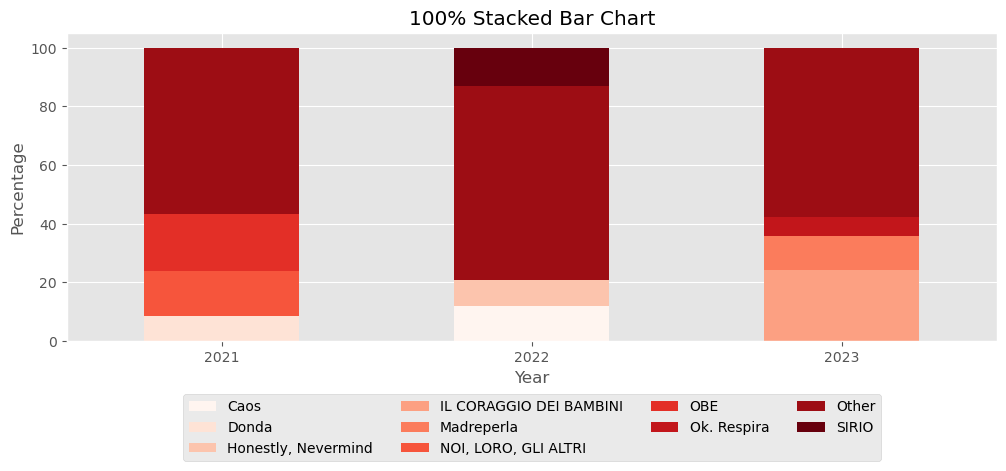

In [48]:
# Filter just last n years
n = 3
current_year = datetime.datetime.now().year
last_n_year = top3_album_yr[current_year-top3_album_yr['year_of_release']<n]

# aggregate the data by year and album to get the total percentage for each album in each year
agg_df = last_n_year.groupby(['year_of_release', 'album'])['%_pc'].sum().unstack(fill_value=0)
agg_df = agg_df.div(agg_df.sum(axis=1), axis=0)

agg_df = agg_df.multiply(100)

import matplotlib.cm as cm

# define the colormap and the normalization
cmap = cm.get_cmap('Reds')

# Creating a bar plot
plt.clf()
    
# plot the stacked bar chart
ax = agg_df.plot(kind='bar', stacked=True, figsize=(12, 4), rot=0, cmap=cmap)

# set the x-axis label
ax.set_xlabel('Year')

# set the y-axis label
ax.set_ylabel('Percentage')

# set the title of the chart
ax.set_title('100% Stacked Bar Chart')

# add legend to the chart
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)